In [ ]:
# =========================================
# 1. Import Libraries
# =========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from joblib import Parallel, delayed

In [ ]:
import pandas as pd
from google.colab import files
uploaded =files.upload()

Saving wsn_landslide_data.csv to wsn_landslide_data.csv


In [ ]:
# =========================================
# 2. Load Dataset
# =========================================
# Load dataset
df = pd.read_csv("wsn_landslide_data.csv")

# Split features and target
X = df.drop(columns=['Label'])
y = df['Label']


In [ ]:
# Set visual theme
sns.set(style="whitegrid")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# ------------------- Linear Regression (OLS Summary) -------------------
# Add constant to training set
X_train_sm = sm.add_constant(X_train)

# Fit OLS model
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Print OLS Summary Report
print("----- LINEAR REGRESSION (OLS SUMMARY) -----\n")
print(ols_model.summary())

----- LINEAR REGRESSION (OLS SUMMARY) -----

                            OLS Regression Results                            
Dep. Variable:                  Label   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     1490.
Date:                Thu, 17 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:19:11   Log-Likelihood:                 2194.4
No. Observations:                7891   AIC:                            -4319.
Df Residuals:                    7856   BIC:                            -4075.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [ ]:
# ------------------- Random Forest Classifier -------------------
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Extract values
tn, fp, fn, tp = conf_matrix.ravel()

# Print results
print("\n----- RANDOM FOREST CLASSIFIER RESULTS -----\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)


----- RANDOM FOREST CLASSIFIER RESULTS -----

Accuracy: 0.9762
True Negatives (TN): 945
False Negatives (FN): 26
Confusion Matrix:
[[945  21]
 [ 26 981]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       966
           1       0.98      0.97      0.98      1007

    accuracy                           0.98      1973
   macro avg       0.98      0.98      0.98      1973
weighted avg       0.98      0.98      0.98      1973



In [ ]:
# Parallel Computing :Spark Preprocessing Step 1: Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

In [ ]:
# Step 2: Start Spark session
spark = SparkSession.builder.appName("LandslideAnalysis").getOrCreate()

In [ ]:
# Step 3: Load the CSV file into Spark DataFrame
df = spark.read.csv("wsn_landslide_data.csv", header=True, inferSchema=True)

In [ ]:
# Step 4: Filter rows where 'Label' is not null (in case of bad entries)
df_cleaned = df.filter(df["Label"].isNotNull())

# Step 5: Preview schema
df_cleaned.printSchema()

root
 |-- Rainfall_mm: double (nullable = true)
 |-- Slope_Angle: double (nullable = true)
 |-- Soil_Saturation: double (nullable = true)
 |-- Vegetation_Cover: double (nullable = true)
 |-- Rainfall_3Day: double (nullable = true)
 |-- Rainfall_7Day: double (nullable = true)
 |-- Aspect: double (nullable = true)
 |-- Elevation_m: double (nullable = true)
 |-- NDVI_Index: double (nullable = true)
 |-- Land_Use_Urban: integer (nullable = true)
 |-- Land_Use_Forest: integer (nullable = true)
 |-- Land_Use_Agriculture: integer (nullable = true)
 |-- Earthquake_Activity: double (nullable = true)
 |-- Proximity_to_Water: double (nullable = true)
 |-- Distance_to_Road_m: double (nullable = true)
 |-- Temperature_C: double (nullable = true)
 |-- Humidity_percent: double (nullable = true)
 |-- Soil_pH: double (nullable = true)
 |-- Clay_Content: double (nullable = true)
 |-- Sand_Content: double (nullable = true)
 |-- Silt_Content: double (nullable = true)
 |-- Soil_Erosion_Rate: double (nullab

In [ ]:
# Showing sample rows
df_cleaned.select("Rainfall_mm", "Slope_Angle", "Label").show(10)

# Step 6: Create binary flag (optional example)
df_flagged = df_cleaned.withColumn("High_Risk_Rainfall", when(col("Rainfall_mm") > 100, 1).otherwise(0))


+-----------+-----------+-----+
|Rainfall_mm|Slope_Angle|Label|
+-----------+-----------+-----+
|164.6953636|59.78333192|    1|
| 34.9080857|15.15308414|    0|
|38.76172694|13.13538426|    0|
|32.19997716|10.67473411|    0|
|218.1140317|48.83926893|    1|
|291.1403214|54.82117331|    1|
|28.51434694| 6.06307551|    0|
|23.84194389|12.44329219|    0|
|10.91269439|17.05540178|    0|
|271.2906378| 50.1481523|    1|
+-----------+-----------+-----+
only showing top 10 rows



In [ ]:
# Step 7: Convert selected features and target to Pandas for further ML use
selected_features = [
    "Rainfall_mm", "Slope_Angle", "Soil_Saturation", "Vegetation_Cover", "Label"
]
pandas_df = df_cleaned.select(*selected_features).toPandas()

# Step 8: Stop Spark session
spark.stop()

In [ ]:
# Python Preprocessing Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Step 2: (Already done in Spark) Load the Pandas DataFrame
# Assume `pandas_df` already has the necessary columns

In [ ]:
# Step 3: Set target and features
X = pandas_df.drop(columns=["Label"])
y = pandas_df["Label"]

In [ ]:
# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:

# Step 6: Predictions
y_pred = model.predict(X_test)

In [ ]:
# Step 7: Evaluation
print("\n=== Evaluation Metrics ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



=== Evaluation Metrics ===
Accuracy: 0.97
Confusion Matrix:
[[1436   32]
 [  44 1448]]


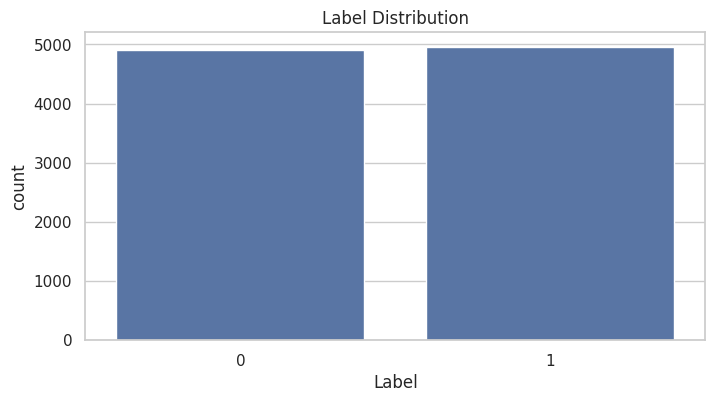

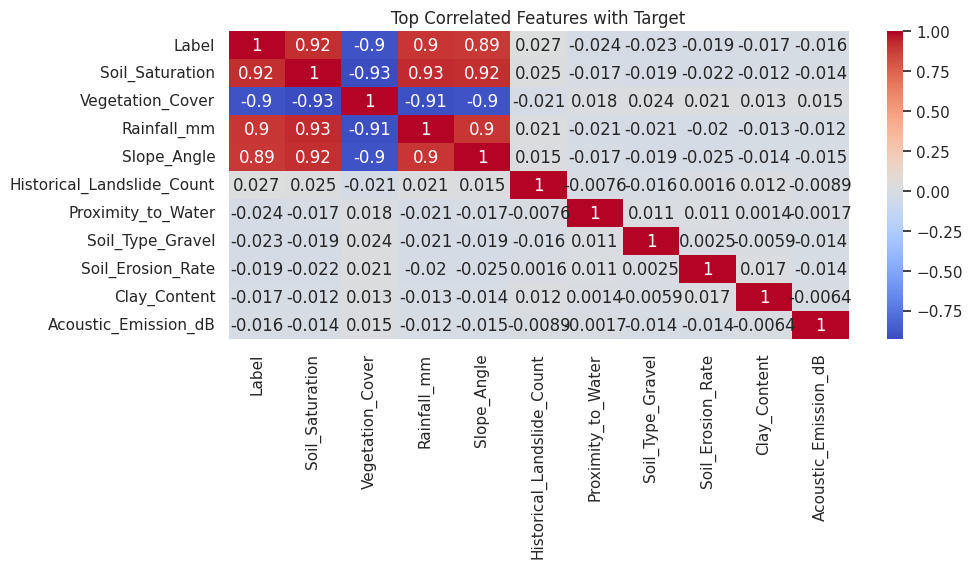

In [ ]:
# =========================================
# 3. EDA
# =========================================
plt.figure(figsize=(8, 4))
sns.countplot(x=y)
plt.title("Label Distribution")
plt.show()

plt.figure(figsize=(10, 4))
corr = df.corr(numeric_only=True)['Label'].abs().sort_values(ascending=False).head(11)
sns.heatmap(df[corr.index].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with Target")
plt.show()

In [ ]:
# =========================================
# 4. Scale + Split
# =========================================
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# =========================================
# 5. Evaluation Function
# =========================================
results = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    dur = time.time() - start
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Train Time (s)": dur
    }

In [ ]:
# =========================================
# 6. Sequential Models
# =========================================
evaluate_model("LogReg (Sequential)", LogisticRegression(max_iter=1000), X_train, X_test, y_train, y_test)
evaluate_model("RandForest (Sequential)", RandomForestClassifier(n_estimators=100), X_train, X_test, y_train, y_test)
evaluate_model("DecisionTree (Sequential)", DecisionTreeClassifier(), X_train, X_test, y_train, y_test)


In [ ]:
# =========================================
# 7. Parallel Models using Joblib
# =========================================
def train_and_evaluate_parallel(name, model):
    start = time.time()
    model.fit(X_train, y_train)
    dur = time.time() - start
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Train Time (s)": dur
    }

parallel_models = [
    ("LogReg (Parallel)", LogisticRegression(max_iter=1000, n_jobs=-1)),
    ("RandForest (Parallel)", RandomForestClassifier(n_estimators=100, n_jobs=-1)),
    ("DecisionTree (Parallel)", DecisionTreeClassifier())
]

In [ ]:
# Run in parallel using joblib
parallel_results = Parallel(n_jobs=3)(
    delayed(train_and_evaluate_parallel)(name, model)
    for name, model in parallel_models
)

In [ ]:
# Add to results
for (name, _), result in zip(parallel_models, parallel_results):
    results[name] = result

In [ ]:
# =========================================
# 8. Compare Results - Table
# =========================================
results_df = pd.DataFrame(results).T
print("\n🔍 Model Comparison:\n")
print(results_df)



🔍 Model Comparison:

                           Accuracy  Precision    Recall  F1 Score   ROC AUC  \
LogReg (Sequential)        0.978206   0.981726  0.974798  0.978250  0.979871   
RandForest (Sequential)    0.978206   0.981726  0.974798  0.978250  0.975341   
DecisionTree (Sequential)  0.938672   0.935936  0.942540  0.939227  0.938650   
LogReg (Parallel)          0.978206   0.981726  0.974798  0.978250  0.979871   
RandForest (Parallel)      0.978206   0.981726  0.974798  0.978250  0.974384   
DecisionTree (Parallel)    0.934110   0.927579  0.942540  0.935000  0.934063   

                           Train Time (s)  
LogReg (Sequential)              0.213549  
RandForest (Sequential)          5.935146  
DecisionTree (Sequential)        0.726931  
LogReg (Parallel)                0.160669  
RandForest (Parallel)            8.444349  
DecisionTree (Parallel)          2.965649  


/tmp/ipython-input-52-2247727993.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-52-2247727993.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-52-2247727993.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-52-2247727993.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


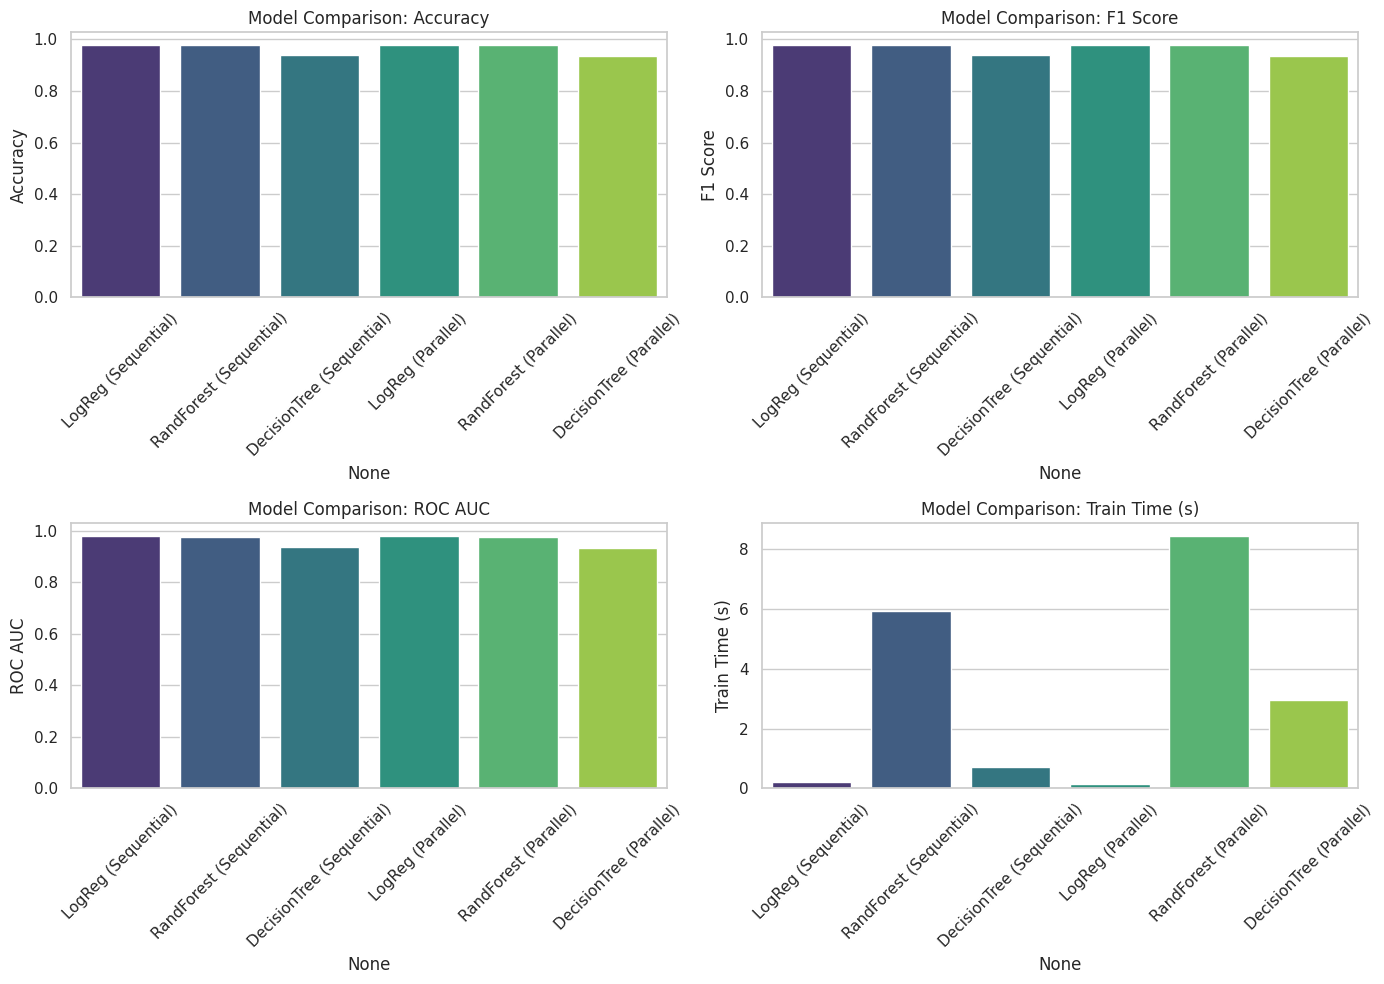

In [ ]:
# =========================================
# 9. Visualization of Metrics
# =========================================

metrics_to_plot = ['Accuracy', 'F1 Score', 'ROC AUC', 'Train Time (s)']

plt.figure(figsize=(14, 10))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.barplot(
        x=results_df.index,
        y=results_df[metric],
        palette='viridis'
    )
    plt.title(f'Model Comparison: {metric}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()